In [20]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

In [21]:
np.random.seed(0)

EXAMPLES_PER_CLASS = 100
USELESS_FEATURES = 1

train_data = []
train_labels = []

for _ in range(EXAMPLES_PER_CLASS):
    train_data.append([0., 0., np.random.random()])
    train_labels.append(0)

    train_data.append([0., 1., np.random.random()])
    train_labels.append(1)

    train_data.append([1., 0., np.random.random()])
    train_labels.append(1)

    train_data.append([1., 1., np.random.random()])
    train_labels.append(0)

train_data, train_labels = torch.tensor(train_data), torch.tensor(train_labels)

test_data = []
test_labels = []

for _ in range(EXAMPLES_PER_CLASS//5):
    test_data.append([0., 0., np.random.random()])
    test_labels.append(0.)

    test_data.append([0., 1., np.random.random()])
    test_labels.append(1.)

    test_data.append([1., 0., np.random.random()])
    test_labels.append(1.)

    test_data.append([1., 1., np.random.random()])
    test_labels.append(0.)

test_data, test_labels = torch.tensor(test_data), torch.tensor(test_labels)

In [22]:
torch.manual_seed(0)
hidden = 10
model = nn.Sequential(
    nn.Linear(2+USELESS_FEATURES, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 2)
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [23]:
epochs = 1000
for epoch in range(epochs):
    y_logits = model(train_data).squeeze()
    y_preds = torch.argmax(y_logits, dim=1)
    
    loss = loss_fn(y_logits, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    if epoch % (epochs//10) == 0:
        with torch.inference_mode():
            y_logits = model(test_data).squeeze()
            y_preds = torch.argmax(y_logits, dim=1)
            acc = accuracy_fn(test_labels, y_preds)
            print(f"[EPOCH {epoch+1}/{epochs}] Loss: {loss} | Accuracy: {acc}")

[EPOCH 1/1000] Loss: 0.7113342881202698 | Accuracy: 50.0
[EPOCH 101/1000] Loss: 0.6114686131477356 | Accuracy: 93.75
[EPOCH 201/1000] Loss: 0.4647417366504669 | Accuracy: 75.0
[EPOCH 301/1000] Loss: 0.2978476285934448 | Accuracy: 100.0
[EPOCH 401/1000] Loss: 0.14997734129428864 | Accuracy: 100.0
[EPOCH 501/1000] Loss: 0.07936517149209976 | Accuracy: 100.0
[EPOCH 601/1000] Loss: 0.04838308319449425 | Accuracy: 100.0
[EPOCH 701/1000] Loss: 0.03300571069121361 | Accuracy: 100.0
[EPOCH 801/1000] Loss: 0.024255048483610153 | Accuracy: 100.0
[EPOCH 901/1000] Loss: 0.018786797299981117 | Accuracy: 100.0


(-0.10000000149011612, 1.100000023841858)

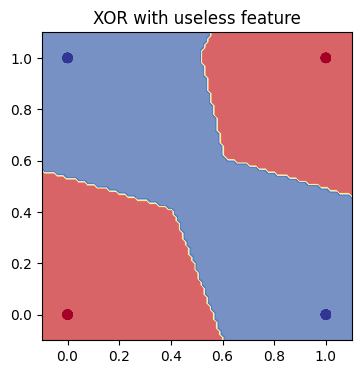

In [24]:
plt.figure(figsize=(4, 4))
plt.title("XOR with useless feature")

x_min, x_max = test_data[:, 0].min() - 0.1, test_data[:, 0].max() + 0.1
y_min, y_max = test_data[:, 1].min() - 0.1, test_data[:, 1].max() + 0.1
z_min, z_max = test_data[:, 2].min() - 0.1, test_data[:, 2].max() + 0.1
xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101), np.linspace(z_min, z_max, 101))

# Make features
X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))).float()

# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_to_pred_on)

# Test for multi-class or binary and adjust logits to prediction labels
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class

# Reshape preds and plot
y_pred = y_pred.reshape(xx.shape).detach().numpy()
plt.contourf(xx[:,:,0], yy[:,:,0], y_pred[:,:,0], cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [25]:
X = test_data.detach().numpy()
T = test_labels.detach().numpy()

In [26]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)
L, W[0].shape, W[1].shape

(2, (3, 10), (10, 2))

In [27]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [29]:
nb_labels = len(np.unique(T))
R = [None] * L + [A[L] * (T[:,None]==np.arange(nb_labels))]

In [30]:
def rho(w, l):  
    return w + [None,0.1,0.0][l] * np.maximum(0,w)
def incr(z, l):
    return z + [None,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [31]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R[l+1] / z
    c = s.dot(w.T)
    R[l] = A[l] * c

In [32]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c - lb*cp - hb*cm

    [Layer 0] [1.8578925  0.00529109 0.24367033]
    [Layer 1] [-0.         -2.4593322  -0.         -0.         -0.          0.
  0.          0.42888394 -0.15281813  4.29012   ]
    [Layer 2] [2.3288631 0.       ]


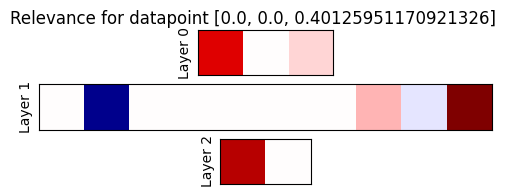

    [Layer 0] [1.8578925  0.00529109 0.24367033]
    [Layer 1] [-0.         -2.4593322  -0.         -0.         -0.          0.
  0.          0.42888394 -0.15281813  4.29012   ]
    [Layer 2] [2.3288631 0.       ]


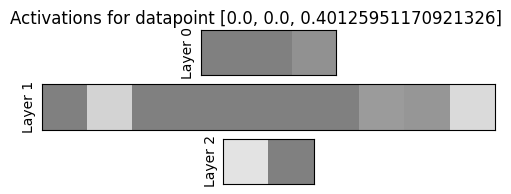

    [Layer 0] [ 1.6323866   0.40702724 -0.04809459]
    [Layer 1] [ 0.          0.65604746  2.6819618   0.          0.         -0.13124463
  0.         -1.2305166   0.01787088 -0.00279937]
    [Layer 2] [0.        2.3447528]


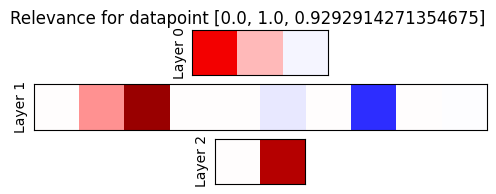

    [Layer 0] [ 1.6323866   0.40702724 -0.04809459]
    [Layer 1] [ 0.          0.65604746  2.6819618   0.          0.         -0.13124463
  0.         -1.2305166   0.01787088 -0.00279937]
    [Layer 2] [0.        2.3447528]


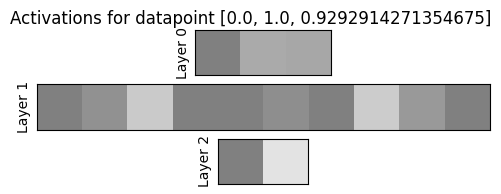

    [Layer 0] [-9.0114009e-01  2.6675005e+00 -1.9224855e-03]
    [Layer 1] [ 0.          2.704969    0.          0.          0.         -0.
  0.         -0.94641596  0.00588497 -0.        ]
    [Layer 2] [0.        2.1199265]


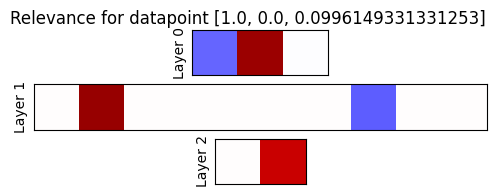

    [Layer 0] [-9.0114009e-01  2.6675005e+00 -1.9224855e-03]
    [Layer 1] [ 0.          2.704969    0.          0.          0.         -0.
  0.         -0.94641596  0.00588497 -0.        ]
    [Layer 2] [0.        2.1199265]


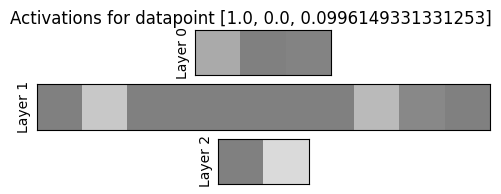

    [Layer 0] [ 0.75924027  0.8244779  -0.05192365]
    [Layer 1] [-0.         -0.2943252  -0.         -0.         -0.          0.07475922
  0.          1.8836389  -0.13227831  0.        ]
    [Layer 2] [1.7697433 0.       ]


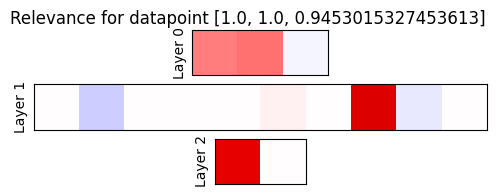

    [Layer 0] [ 0.75924027  0.8244779  -0.05192365]
    [Layer 1] [-0.         -0.2943252  -0.         -0.         -0.          0.07475922
  0.          1.8836389  -0.13227831  0.        ]
    [Layer 2] [1.7697433 0.       ]


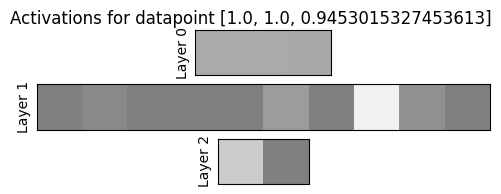

    [Layer 0] [1.8164198  0.00191577 0.15286806]
    [Layer 1] [-0.         -2.560346   -0.         -0.         -0.          0.
  0.          0.55012083 -0.21899672  4.2004256 ]
    [Layer 2] [2.1883745 0.       ]


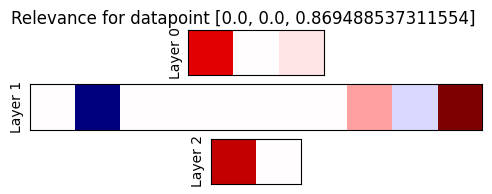

    [Layer 0] [1.8164198  0.00191577 0.15286806]
    [Layer 1] [-0.         -2.560346   -0.         -0.         -0.          0.
  0.          0.55012083 -0.21899672  4.2004256 ]
    [Layer 2] [2.1883745 0.       ]


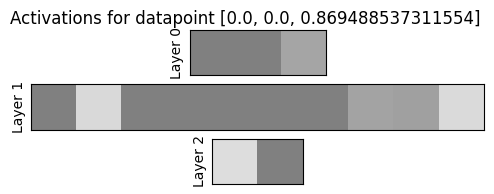

    [Layer 0] [ 1.6412747   0.39606738 -0.02947235]
    [Layer 1] [ 0.          0.45630664  2.7094102   0.          0.         -0.06722724
  0.         -1.1010935   0.01047376 -0.        ]
    [Layer 2] [0.       2.364846]


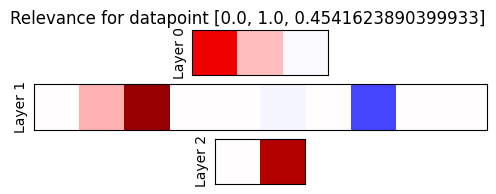

    [Layer 0] [ 1.6412747   0.39606738 -0.02947235]
    [Layer 1] [ 0.          0.45630664  2.7094102   0.          0.         -0.06722724
  0.         -1.1010935   0.01047376 -0.        ]
    [Layer 2] [0.       2.364846]


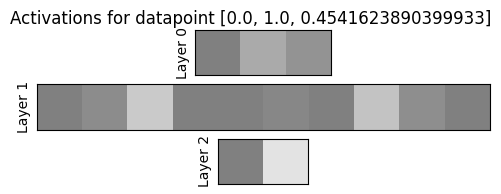

    [Layer 0] [-8.6937726e-01  2.6666448e+00 -7.2368665e-04]
    [Layer 1] [ 0.          2.7996967   0.          0.          0.         -0.
  0.         -1.012632    0.00947919 -0.        ]
    [Layer 2] [0.        2.1515925]


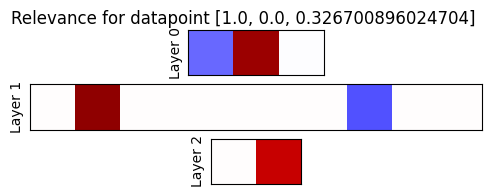

    [Layer 0] [-8.6937726e-01  2.6666448e+00 -7.2368665e-04]
    [Layer 1] [ 0.          2.7996967   0.          0.          0.         -0.
  0.         -1.012632    0.00947919 -0.        ]
    [Layer 2] [0.        2.1515925]


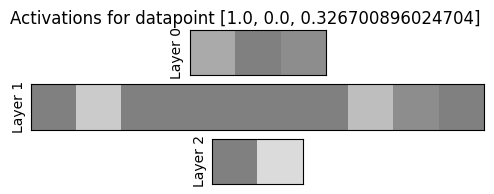

    [Layer 0] [0.80162627 0.8687844  0.04209261]
    [Layer 1] [-0.         -0.03769309 -0.         -0.         -0.          0.04764489
  0.          1.7194556  -0.01690406  0.        ]
    [Layer 2] [1.9581019 0.       ]


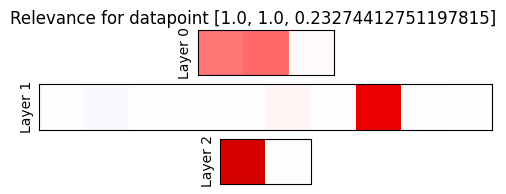

    [Layer 0] [0.80162627 0.8687844  0.04209261]
    [Layer 1] [-0.         -0.03769309 -0.         -0.         -0.          0.04764489
  0.          1.7194556  -0.01690406  0.        ]
    [Layer 2] [1.9581019 0.       ]


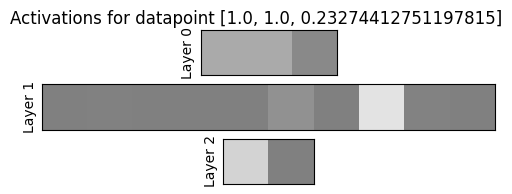

In [35]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

for i in range(8):
    #print(f"[POINT] {data[i].tolist()}")

    # -- Display relevance --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(R[l][i].reshape((1, len(R[l][i]))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Relevance for datapoint {X[i].tolist()}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(A[l][i].reshape((1, len(A[l][i]))), cmap="gray_r", interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Activations for datapoint {X[i].tolist()}")
    plt.show()

### Average relevance
#### Entire dataset

    [Layer 0] R: [0.8516034  0.9769498  0.04735396]
    [Layer 1] R: [ 0.00188389  0.17491183  0.6774542   0.          0.         -0.01046975
  0.          0.01915808 -0.05316855  1.0661378 ]
    [Layer 2] R: [1.0418637 1.1273692]


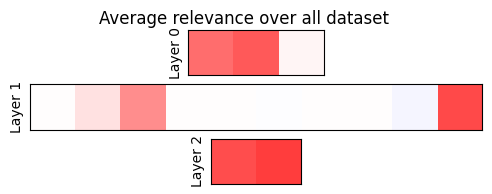

    [Layer 0] A: [0.5        0.5        0.51131016]
    [Layer 1] A: [0.00960249 1.0563555  0.43520433 0.         0.         0.19858772
 0.         1.5849278  0.38886786 0.5326999 ]
    [Layer 2] A: [1.0418637 1.1273692]


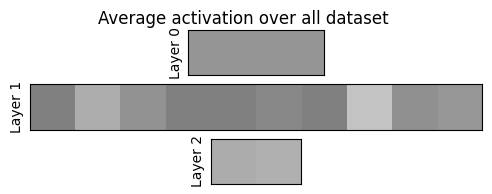

In [36]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

# -- Display relevance --
fig, axs = plt.subplots(L+1, 1)
b = 3
for l in range(L+1):
    relevance = np.mean(R[l], axis=0)

    axs[l].imshow(relevance.reshape((1, len(relevance))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
    axs[l].figure.set_size_inches(10, 2)
    print(f"    [Layer {l}] R: {relevance}")
    axs[l].set_xticks([])
    axs[l].set_yticks([])
    axs[l].set_ylabel(f"Layer {l}")

fig.suptitle(f"Average relevance over all dataset")
plt.show()

# -- Display activations --
fig, axs = plt.subplots(L+1, 1)
b = 3
for l in range(L+1):
    activation = np.mean(A[l], axis=0)

    axs[l].imshow(activation.reshape((1, len(activation))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
    axs[l].figure.set_size_inches(10, 2)
    print(f"    [Layer {l}] A: {activation}")
    axs[l].set_xticks([])
    axs[l].set_yticks([])
    axs[l].set_ylabel(f"Layer {l}")

fig.suptitle(f"Average activation over all dataset")
plt.show()

#### Grouped by class

    [Layer 0] R: [1.8469982  0.00464271 0.21989176]
    [Layer 1] R: [ 0.         -2.4847686   0.          0.          0.          0.
  0.          0.45995528 -0.16979626  4.2661424 ]
    [Layer 2] R: [2.2922509 0.       ]


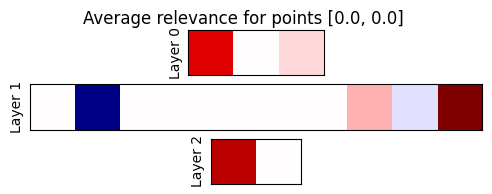

    [Layer 0] A: [0.        0.        0.5232843]
    [Layer 1] A: [0.        2.0118568 0.        0.        0.        0.        0.
 0.701904  0.5853368 2.130032 ]
    [Layer 2] A: [2.2922509 0.       ]


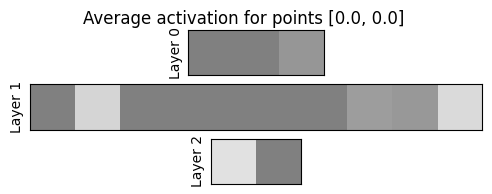

    [Layer 0] R: [ 1.6389021   0.39952698 -0.02344054]
    [Layer 1] R: [ 7.5485194e-03  4.5942664e-01  2.7098167e+00  0.0000000e+00
  0.0000000e+00 -6.8203405e-02  0.0000000e+00 -1.1033580e+00
  1.0587366e-02 -8.2942209e-04]
    [Layer 2] R: [0.        2.3720198]


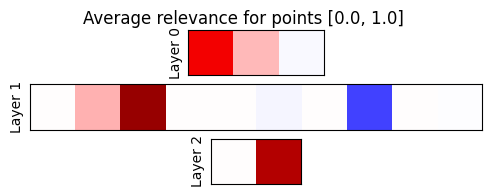

    [Layer 0] A: [0.         1.         0.46363792]
    [Layer 1] A: [3.7081726e-02 2.8797621e-01 1.7408173e+00 0.0000000e+00 0.0000000e+00
 1.8127030e-01 0.0000000e+00 1.5968518e+00 3.4545210e-01 3.9837361e-04]
    [Layer 2] A: [0.        2.3720198]


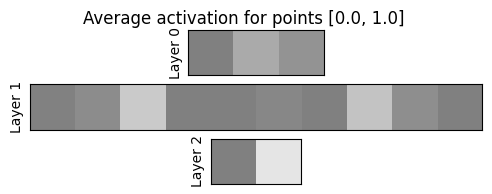

    [Layer 0] R: [-0.8631835   2.653588   -0.00614505]
    [Layer 1] R: [ 0.0000000e+00  2.8720775e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -3.2565292e-02  0.0000000e+00 -1.0671152e+00
  1.2623789e-02 -7.6183688e-04]
    [Layer 2] R: [0.        2.1374564]


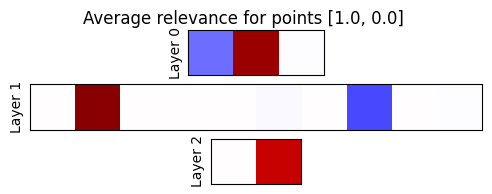

    [Layer 0] A: [1.         0.         0.53105366]
    [Layer 1] A: [0.0000000e+00 1.8161150e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 8.7625213e-02 0.0000000e+00 1.5609499e+00 4.1582337e-01 3.6928654e-04]
    [Layer 2] A: [0.        2.1374564]


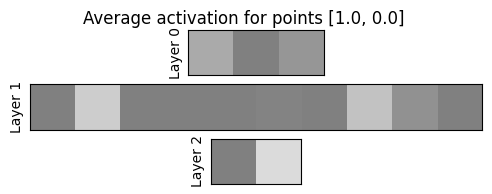

    [Layer 0] R: [ 0.78369695  0.85004294 -0.00089037]
    [Layer 1] R: [-1.2966959e-05 -1.4708833e-01  0.0000000e+00  0.0000000e+00
  0.0000000e+00  5.8889676e-02  0.0000000e+00  1.7871501e+00
 -6.6089086e-02  0.0000000e+00]
    [Layer 2] R: [1.8752041 0.       ]


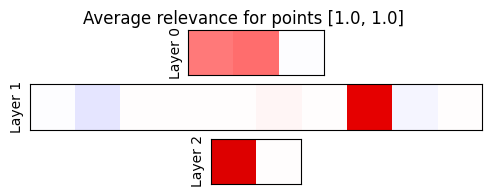

    [Layer 0] A: [1.         1.         0.52726495]
    [Layer 1] A: [1.3282172e-03 1.0947379e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 5.2545542e-01 0.0000000e+00 2.4800055e+00 2.0885918e-01 0.0000000e+00]
    [Layer 2] A: [1.8752041 0.       ]


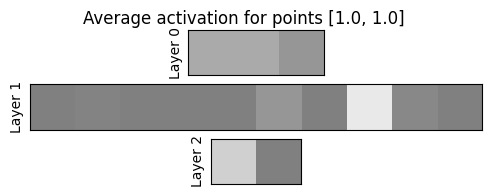

In [37]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

# -- Display relevance --
for i in range(4):
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        relevance = np.mean(R[l][i::4], axis=0)

        axs[l].imshow(relevance.reshape((1, len(relevance))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] R: {relevance}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    point = X[i].tolist()
    point.pop() # remove useless feature from display

    fig.suptitle(f"Average relevance for points {point}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        activation = np.mean(A[l][i::4], axis=0)

        axs[l].imshow(activation.reshape((1, len(activation))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] A: {activation}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Average activation for points {point}")
    plt.show()